# Feature Maps & Visualization

Feature maps are a crucial concept in deep learning, particularly in convolutional neural networks (CNNs). They represent the outputs of convolutional layers, capturing the spatial hierarchies and patterns learned by the model. This chapter will delve into the concept of feature maps, their visualization, significance, and introduce a popular tool for feature map visualization - `pytorch-grad-cam`.

## What are Feature Maps?

In deep learning, feature maps are the result of applying convolutional filters to the input data. Each filter is designed to detect specific patterns such as edges, textures, or more complex structures in the data. As the data passes through multiple convolutional layers, the network learns increasingly abstract and high-level features.

### Example

Consider a CNN trained to classify images of cats and dogs. In the initial layers, feature maps might highlight simple edges or colors. As the data progresses through the network, the feature maps become more sophisticated, identifying shapes, textures, and eventually, more abstract features like the presence of fur or specific body parts.

![FeatureMap](../imgs/FeatureMap.jpg)

## Visualizing Feature Maps

Visualizing feature maps helps understand what a neural network is learning and can provide insights into its decision-making process. By examining feature maps, we can ensure that the network is focusing on relevant parts of the input and identify potential issues such as overfitting or underfitting.

### Methods of Visualization

1. **Activation Maps**: These are the raw outputs of the convolutional layers. By plotting these activations, we can observe which parts of the input data are being highlighted by each filter.
2. **Grad-CAM (Gradient-weighted Class Activation Mapping)**: This technique uses the gradients of any target concept (like the logits corresponding to a certain class) flowing into the final convolutional layer to produce a coarse localization map, highlighting important regions in the image.

## Introducing pytorch-grad-cam

`pytorch-grad-cam` is a powerful and easy-to-use library for visualizing the feature maps and class activation maps in PyTorch models. It supports several variants of CAM, including Grad-CAM, Score-CAM, and Grad-CAM++.

### Python Code Example

In [1]:
import numpy as np
import torchvision.models as models
import pytorch_grad_cam 
from pytorch_grad_cam.utils.image import show_cam_on_image

resnet18 = models.resnet18(pretrained=True)
resnet18.eval()
print(resnet18)

D:\Anaconda\envs\bdl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\envs\bdl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\bdl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466563..2.6051404].


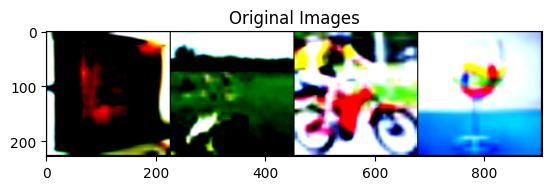

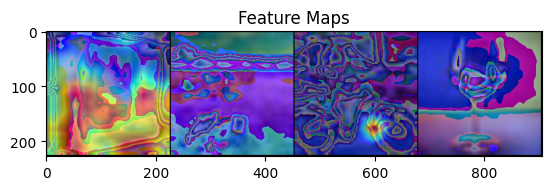

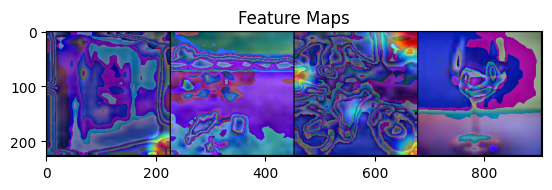

In [2]:
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

class Show:
    def __init__(self, model, target_layers, batch_size):
        self.model = model
        self.target_layers = target_layers
        self.batch_size = batch_size
        
        trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        ROOT = '.data'
        dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=trans)
        self.loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    def imshow(self, imgs, title):
        npimg = imgs.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(title)
        plt.show()

    def vis_imgs(self):
        dataiter = iter(self.loader)
        imgs, _ = next(dataiter)

        def get_vis_imgs(cam, batch_size=self.batch_size, imgs=imgs):
            visualization_imgs = []
            for i in range(batch_size):
                img = imgs[i]
                net_input = img.unsqueeze(0)
                canvas_img = (img * 255).byte().numpy().transpose(1, 2, 0)
            
                grayscale_cam = cam(input_tensor=net_input)[0, :]
                src_img = np.float32(canvas_img) / 255
                visualization_img = show_cam_on_image(src_img, grayscale_cam, use_rgb=True)
                visualization_imgs.append(torch.from_numpy(visualization_img).permute(2, 0, 1))
            return visualization_imgs

        self.imshow(torchvision.utils.make_grid(imgs), "Original Images")
        for target_layer in self.target_layers:
            cam = pytorch_grad_cam.GradCAMPlusPlus(model=self.model, target_layers=target_layer)
            self.imshow(torchvision.utils.make_grid(get_vis_imgs(cam=cam)), "Feature Maps")

target_layers = [[resnet18.layer4[0].conv1], [resnet18.layer4[1].conv1]]
imgs = Show(model=resnet18, target_layers=target_layers, batch_size=4)
imgs.vis_imgs()